In [2]:
import numpy as np
import easier as ezr
import pylab as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config Completer.use_jedi = False

In [135]:
class Element:
    c = 3e8
    def __init__(self, freq, r0_vector_in_wavelengths, phase=0, name=''):
        self.phi0 = phase 
        self.f = freq
        self.lamda = self.c / self.f
        self.k = 2 * np.pi / self.lamda
        self.r0 = self.lamda * np.array(r0_vector_in_wavelengths)
        self.name = name
        
    def phase_to(self, r_vector):
        R_vector = np.array(r_vector) - self.r0
        R_mag = np.sqrt(np.sum(R_vector ** 2, axis=-1))
        phase = self.k * R_mag
        return np.exp(1j * (phase - self.phi0))
    
    @ezr.cached_property
    def r(self):
        return np.sqrt(np.sum(self.r0 ** 2)) / self.lamda
    
    def set_phase(self, phase):
        self.phi0 = phase
    
    
class Array:
    def __init__(self, freq, coords, names=None):
        """
        args = list of lists.  [[x1, y1, phase_radians1], ... [xN, yN, phase_radiansN]]
        """
        if names is None:
            names = ['' for c in coords]
        self.elements = [Element(freq, coord, name=name) for (coord, name) in zip(coords, names)]
        
    def plot_elements(self):
        x = []
        y = []
        names = []
        for el in self.elements:
            x.append(el.r0[0] / el.lamda)
            y.append(el.r0[1] / el.lamda)
            names.append(el.name)
            
        ax = ezr.figure(figsize=(3, 3), grid=False)
        ax.scatter(x, y)
        
        for (xi, yi, name) in zip(x, y, names):
            if name:
                ax.text(xi, yi, name, ha='left', va='bottom', size='large')
        ax.axis('square')
        ax.set_xlabel('x')
        ax.set_ylabel('y')

    def plot_pattern(self, show=True, ax=None, label=None):
        r = 1000 * max([e.r for e in self.elements])
        phi = np.linspace(0, 2 * np.pi, 3000)
        x_vals = r * np.cos(phi)
        y_vals = r * np.sin(phi)
        XY = np.vstack((x_vals, y_vals)).T
        
        Z = np.zeros_like(phi)
        for element in self.elements:
            Z = Z + element.phase_to(XY)
            
        P = (np.conj(Z) * Z).real
        P = P / np.mean(P)
        
        P = 10 * np.log10(P + 1e-6)
        P = np.maximum(P, -20)
        
        if ax is None:
            fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8,8))
        ax.plot(phi, P, label=label)
        ax.grid(True)
        
        min_val = np.max([-10, np.floor(np.min(P)) - 1])
        max_val = np.ceil(np.max(P)) + 1
        ax.set_ylim(min_val, max_val)
        
        #################
#         n = 60
#         ax.set_xticks(np.linspace(0, 2* np.pi * (1 - 1/(n-1)), n-1))
        ticks = np.arange(0, 360, 10) * np.pi / 180
        ax.set_xticks(ticks)
        ################3
        
        
        #########33
        gain_array.append(np.round(np.max(P), 2))
        #########
        ax.set_title(f'gmax={np.round(np.max(P), 2)}', va='bottom')
        if show:
            plt.show()
        return ax
        
        
    
class DeltaArray(Array):
    def __init__(self, freq, side_in_wavelengths=.25):
        k = 2 * np.pi
        s = side_in_wavelengths
        self.s, self.k = s, k
        
        theta_b = 0
        
        coords = [
            [0, 0],
            [s, 0] 
        ]
        
        names = [
            'a',
            'b',
        ]
        
        super().__init__(freq, coords, names)
        
    def plot_pattern(self, theta_degrees, ax=None):
        theta = np.pi * theta_degrees / 180
        s = self.s
        k = self.k
        phase_b = (-k * s * np.cos(theta)) % (2 * np.pi)
        phase_lookup = {
            'a': 0,
#             'b': -k * s * np.cos(theta),
            'b': phase_b,
        }
        self.phase_lookup = phase_lookup
        for element in self.elements:
            element.set_phase(phase_lookup[element.name])
        ax = super().plot_pattern(show=False, ax=ax, label=str(theta_degrees))
        phase_a = np.round(phase_lookup['a'] * 180 / np.pi, 0)
        phase_b = np.round(phase_lookup['b'] * 180 / np.pi, 0)
        print('***', theta_degrees, phase_b)
#         phase_c = np.round(phase_lookup['c'] * 180 / np.pi, 0)
        
        title = f'dir={theta_degrees} {ax.get_title()}  a={phase_a} b={phase_b}'
        ax.set_title('')
        return ax


*** 0 72.0
*** 50 175.0
*** 75 285.0
[3.27, 2.34, 3.18]


2.34

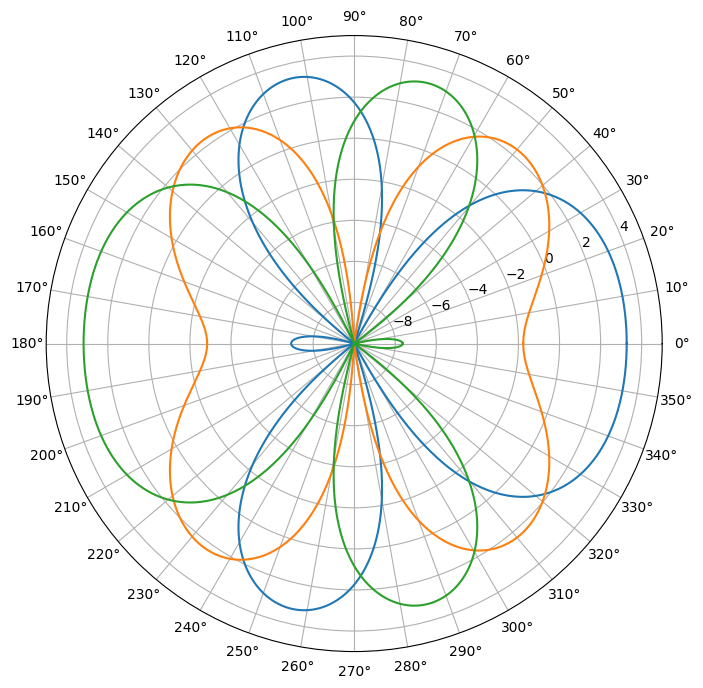

In [137]:
gain_array = []    
array = DeltaArray(freq=7.15e6, side_in_wavelengths=.8)
ax = array.plot_pattern(theta_degrees=0)
ax = array.plot_pattern(theta_degrees=50, ax=ax)
ax = array.plot_pattern(theta_degrees=75, ax=ax)
# ax = array.plot_pattern(theta_degrees=90, ax=ax)
# ax.legend(loc='lower left')

# pl.show()

print(gain_array)
min(gain_array)